# Sistema de recomendacion para peliculas

$$\color{red}{\textbf{Correr en kernel 3.9.1 para que funcione}}$$

In [1]:
#%matplotlib inline
from collections import defaultdict
import json
import gzip
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import pandas as pd

from matplotlib import rcParams
import matplotlib.cm as cm
import matplotlib as mpl

La data de este caso la encontraras en este enlace: https://drive.google.com/drive/folders/1GfmYDzs1wfMkKqO3qtkhmZ6Z54ObfNqw?usp=share_link

## Metas

En este caso, creará un **sistema de recomendación** para películas utilizando **[filtrado colaborativo](http://en.wikipedia.org/wiki/Collaborative_filtering) (CF)**. El filtrado colaborativo se basa en las reseñas de los usuarios en una lista de elementos y utiliza el comportamiento anterior de los usuarios para recomendar elementos que aún no han probado pero que podrían interesarles.

Existen dos enfoques principales para la FQ: **comparación basada en el vecindario (neighborhood-based comparison)** y **modelo de factor latente (latent factor modeling)**. El primero se ocupa de calcular las relaciones entre elementos o entre usuarios. En el último enfoque, tiene un modelo de factores ocultos a través del cual los usuarios y los elementos se transforman en el mismo espacio. Por ejemplo, si está clasificando películas, podemos transformar los elementos en diferentes géneros y los usuarios en su preferencia por un género en particular. Al final del caso, aprenderá cómo hacer CF usando ambos enfoques.

## Introduccion

**Contexto comercial.** La mayoría de las empresas comerciales en línea utilizan sistemas de recomendación automatizados para aumentar la participación del cliente. Un sistema de recomendaciones eficiente y preciso conecta a los clientes con negocios y servicios que nunca antes han usado, pero con los que muy probablemente se comprometerían. Usted es el ingeniero jefe de una empresa nueva que tiene como objetivo brindar experiencias de entretenimiento personalizadas. Su empresa quiere que cree un sistema de recomendación que sugiera películas y programas de televisión que satisfagan los gustos de los usuarios.

**Problema comercial.** Su tarea principal es usar las reseñas que sus usuarios escribieron sobre películas y programas de TV en Amazon **para crear un sistema de recomendación automático que prediga la probabilidad de que un usuario disfrute de una película, según que también generará una lista de películas/programas de televisión que el usuario nunca ha visto antes pero que probablemente disfrutaría.**

**Contexto analítico.** El esquema de este caso es el siguiente: (1) crearemos una base de datos de similitudes entre elementos y la usaremos para implementar un recomendador de FC basado en el vecindario que pueda responder preguntas simples como "dame más películas como ésta". Esta parte del caso asume que las similitudes calculadas hacen buenas "recomendaciones globales"; (2) ir un paso más allá e intentar predecir la calificación que un usuario le dará a una película que no ha visto antes. Esto requiere que encontremos las películas que *este* usuario calificaría como similares (no solo aquellas que son similares en todos los ámbitos); y finalmente (3) implementar un recomendador de FC basado en factores latentes utilizando una factorización de matriz no negativa.

## Neighborhood Based Comparison vs. Latent Factors

Como se mencionó anteriormente, existen dos enfoques principales para la FQ: **comparación basada en el vecindario** y **modelado de factores latentes**.

Los enfoques originales de la CF basada en el vecindario utilizaron modelos de usuario a usuario. Esto significa que estimaríamos la calificación que un usuario en particular le daría a un artículo en particular en función de las calificaciones reales que otros usuarios similares le dieron a ese artículo. Sin embargo, dado que la mayoría de los usuarios tiende a calificar muy pocos elementos, esta no suele ser la mejor manera de construir sistemas de recomendación centrados en calificaciones. Por lo tanto, la mayoría de los sistemas basados en vecindarios en estos días (por ejemplo, Amazon) se basan en enfoques de artículo a artículo. En este enfoque, una calificación se estima utilizando la calificación que el usuario en particular dio a otros elementos similares; es decir, efectivamente tenemos una especie de algoritmo de vecinos más cercanos de $k$.

Los modelos de factores latentes generalmente conducen a recomendaciones más precisas. Una de las razones de esto es la escasez de la matriz artículo-usuario. La mayoría de los usuarios tiende a calificar apenas uno o dos elementos. Los modelos de factores latentes son más expresivos y se ajustan a menos parámetros. Sin embargo, los modelos de neighborhood son más frecuentes, ya que tienen un aspecto intuitivo que atrae a los usuarios (si te gustó esto, te gustará aquello) y en línea (una nueva preferencia se puede incorporar muy rápidamente).

## Explorando el datase 

Los datos que utilizamos son una versión reducida de las reseñas de películas y programas de televisión de Amazon (disponibles [aquí](http://jmcauley.ucsd.edu/data/amazon/)). Cada entrada en este DataFrame es una revisión específica en la que solo registramos la identificación del usuario, la identificación de la película y la calificación de la película. También tenemos una lista de metadatos que se pueden usar para asignar ID de películas a títulos de películas reales:

In [6]:
# diccionario para mapear la paelicula con los titulos
movie_title_dict = {}
with gzip.open('meta_Movies_and_TV.json.gz', 'rt', encoding='ascii') as zipfile:
    for line in zipfile:
        tmp = json.loads(line)
        try:
            movie_title_dict[tmp['asin']] = tmp['title']
        except KeyError:
            continue

In [9]:
[(key, value) for i, (key, value) in enumerate(movie_title_dict.items()) if i < 5]

[('0000695009', 'Understanding Seizures and Epilepsy'),
 ('0000791156', "Spirit Led—Moving By Grace In The Holy Spirit's Gifts"),
 ('0000143529', 'My Fair Pastry (Good Eats Vol. 9)'),
 ('0000143588',
  "Barefoot Contessa (with Ina Garten), Entertaining With Ina Vol. 2 (3 Pack): Brunch 'n' Lunch, Picnic Parties, Summer Entertaining"),
 ('0000143502', 'Rise and Swine (Good Eats Vol. 7)')]

In [10]:
fulldf=pd.read_csv("amazon_movie_reviews.csv")
fulldf.head(2)

,item,user,rating
0,0001527665,A3478QRKQDOPQ2,5.0
1,0001527665,A2VHSG6TZHU1OB,5.0


In [11]:
fulldf.shape

(4382784, 3)

Las variables son:

* **rating**: star rating (integer 1 - 5)
* **item**: unique ID for a movie
* **user**: unique ID for a user

### Ejercicio 1

En este conjunto de datos, ¿cuántos usuarios tienen más de una reseña para una sola película? Para estos usuarios, ¿siempre le dan la misma calificación a la misma película? Si un usuario reseña una película más de una vez y las calificaciones son diferentes, ¿qué le gustaría hacer para agregar todas estas reseñas? Escribe código para implementar lo que propones.


In [12]:
check = fulldf.groupby(['user','item']).size().reset_index(name='count')
print("No. de users que dieron un review solo una vez:", len(check[check['count']>1].user.unique()))

No. de users que dieron un review solo una vez: 206800


In [13]:
check_diff = fulldf.groupby(['user','item']).agg({'rating':['size','std']}).reset_index()
check_diff.columns = ['_'.join(col).strip("_") for col in check_diff.columns.values]

In [19]:
check_diff[~check_diff['rating_std'].isnull()]

,user,item,rating_size,rating_std
19,A0028738FYF1SKPPC7B1,B00164KYV4,2,0.0
21,A00311542N70JGNHUZPI,B0014Z3OQW,2,0.0
25,A0032752LTC7FRSBF7K,B000WMA6R8,2,0.0
36,A0040548BPHKXMHH3NTI,B0013J30YU,2,0.0
75,A0072041HVZ3465DXUOR,B0013D8LP4,2,0.0
...,...,...,...,...
4132303,AZZTW3LYCZL3B,B00127RAJY,2,0.0
4132316,AZZUN29K6LD34,B000WGWQG8,2,0.0
4132393,AZZYUA6JI1MO0,B000YW8RN6,2,0.0
4132409,AZZZ159U3Q5OO,B000A8NZ0O,2,0.0


In [15]:
print("No. de combinaciones user+movie con mas de un review:", check_diff[(check_diff.rating_size>1) & (check_diff.rating_std>0)].shape[0] )

No. de combinaciones user+movie con mas de un review: 2748


Los resultados anteriores indican que algunos usuarios revisan una sola película varias veces con diferentes calificaciones. Elegimos tomar el **promedio** de estas calificaciones para agregarlas:

In [20]:
usedf = fulldf.groupby(['user','item']).agg({'rating':['mean']}).reset_index()
usedf.columns = [col[0] for col in usedf.columns.values]

In [21]:
usedf

,user,item,rating
0,A0001392IVCRENBEIEYS,6302409365,5.0
1,A0002090WKEMAO8KOWKM,779913027X,5.0
2,A0002090WKEMAO8KOWKM,B0036TGSWG,5.0
3,A00049826E18XJLZ3YC0,B001FB55JO,5.0
4,A0007430W3WXY3QNYB2S,B003HC9JIW,5.0
...,...,...,...
4132423,AZZZKII78NDE9,B00020HAY2,5.0
4132424,AZZZMSZI9LKE6,6303421156,4.0
4132425,AZZZMSZI9LKE6,B00008DDJD,5.0
4132426,AZZZMSZI9LKE6,B000OYCMMQ,5.0


A partir de ahora, trabajaremos con `usedf` para todos los análisis.

Comencemos explorando `usedf`. Trazaremos dos histogramas, uno del número de reseñas por usuario y otro del número de reseñas por artículo:

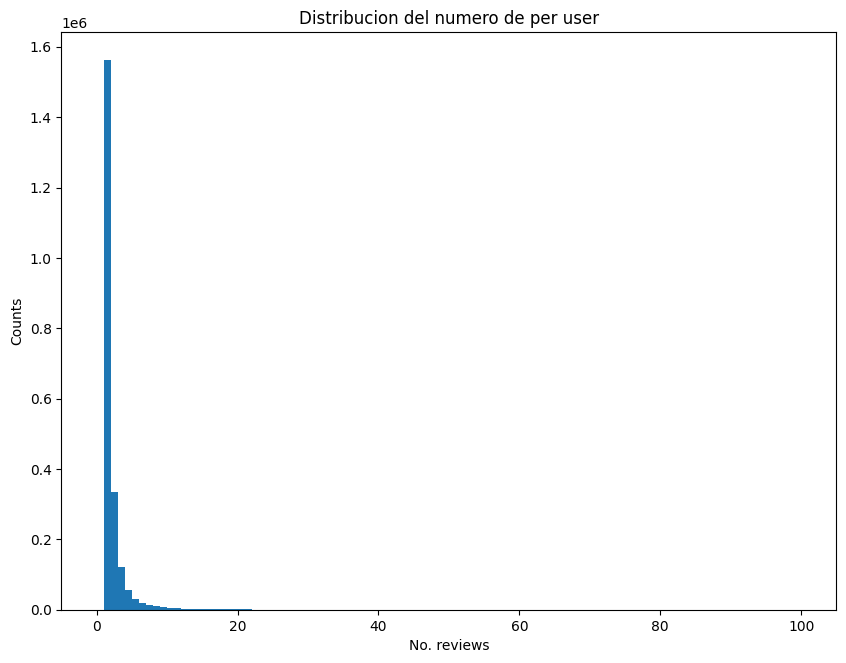

In [22]:
def myhist( data, title, xlab, n_bins = 100, density = False, range = [0,100] ):
    fig = plt.figure( figsize=(10,7.5) )
    ax = plt.gca()
    n, bins, patches = ax.hist( data, bins = n_bins, density = density, range = range )
    plt.xlabel( xlab )
    if density:
        plt.ylabel( "Density" )
    else:
        plt.ylabel( "Counts" )
    plt.title( title )

myhist( usedf.groupby( "user" ).size(), "Distribucion del numero de per user", "No. reviews" )

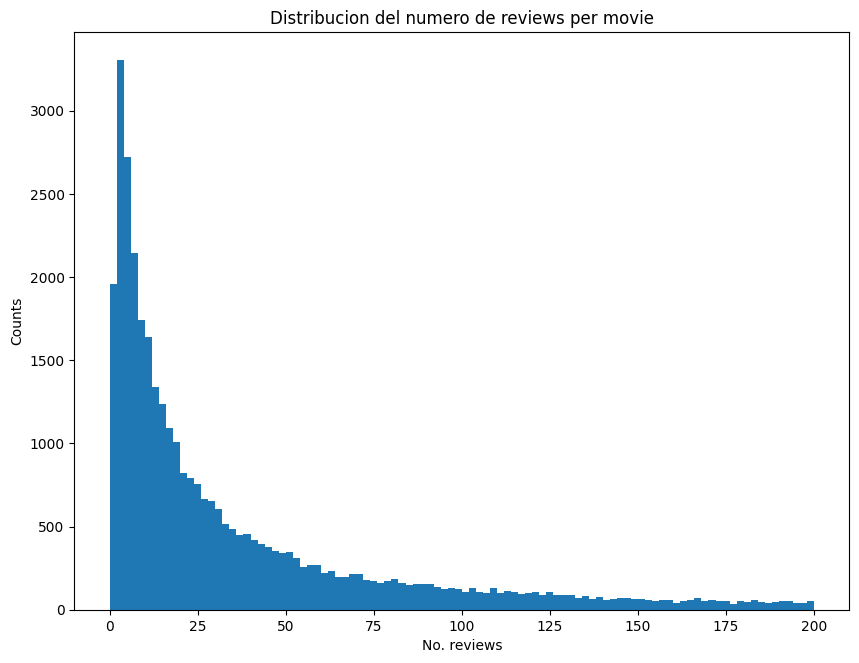

In [23]:
myhist(usedf.groupby( "item" ).size(), "Distribucion del numero de reviews per movie", "No. reviews", range = [0,200] )

In [24]:
print("Numero de usuarios", usedf.user.unique().size)
print("Numero de movies", usedf.item.unique().size)

Numero de usuarios 2189850
Numero de movies 38995


Podemos encontrar que la gran mayoría de los usuarios califican menos de 25 películas, lo que significa que la mayoría de los usuarios no expresan sus opiniones por más de $ 1 - \frac{38970}{38995}\approx 0.01\%$ de las películas. La distribución del número de reseñas por película generalmente se agrupa por debajo de 200. Esto significa que la mayoría de las películas no reciben comentarios de más de $1 - \frac{2189650}{2189850}\approx 0.01\%$ usuarios. Estos números pueden sugerir que el conjunto de datos es bastante escaso; es decir, contiene muchos "datos faltantes". Esto corrobora nuestra declaración anterior con respecto a los modelos de comparación basados en vecindarios; es decir, que cada usuario revisa relativamente pocos elementos y, de hecho, cada elemento es revisado por relativamente pocos usuarios (aunque en promedio es considerablemente más alto que el primero).

También podemos calcular la calificación promedio de las revisiones en el conjunto de datos y trazar un histograma de todas las calificaciones en el conjunto de datos:

Promedio de rating de reviews en dataset es 4.30


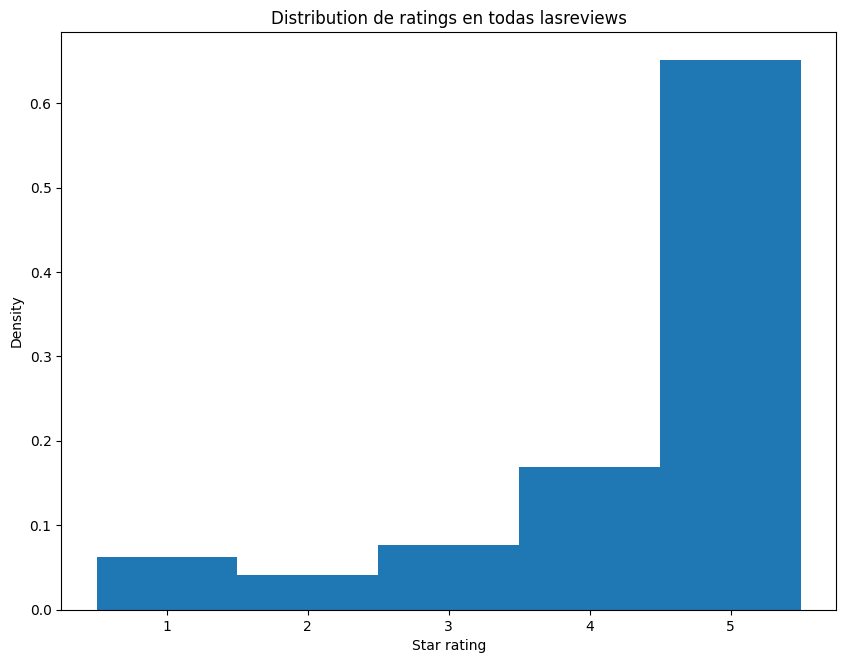

In [25]:
print("Promedio de rating de reviews en dataset es %.2f" % usedf.rating.mean())
myhist( usedf.rating, "Distribution de ratings en todas lasreviews", "Star rating", 
       n_bins = np.linspace( 0.5, 5.5, num = 6 ), density = True, range = [0,6]  )

Podemos ver que el histograma no es uniforme; hay una fracción no significativa (~8%) de 1 calificación y un grupo grande de 5 calificaciones. Esto es muy común en las reseñas de películas.

### Creando un dataste pequeño

Ahora vamos a crear un conjunto de datos más pequeño en DataFrame `smalldf` buscando esas películas con más de 2200 reseñas (películas populares/clásicas) y esos usuarios con más de 65 reseñas. Tenga en cuenta que, si bien este corte garantiza que tengamos usuarios prolíficos, el corte en las películas restablece la escasez al reducir la cantidad de reseñas por usuario. También incluimos en `smalldf` una columna `user_mean` para indicar la calificación promedio que otorga un usuario y una columna `movie_mean` para indicar la calificación promedio que recibe esta película. Después del filtrado inicial, eliminamos aún más a los usuarios que ahora tienen menos de 6 reseñas y películas con menos de 3 reseñas:

In [26]:
#get subset
df1 = usedf.groupby("user").size().reset_index(name="count_user")
df1

,user,count_user
0,A0001392IVCRENBEIEYS,1
1,A0002090WKEMAO8KOWKM,2
2,A00049826E18XJLZ3YC0,1
3,A0007430W3WXY3QNYB2S,1
4,A00086729ZDSXGG2E481,1
...,...,...
2189845,AZZZBE3LCDP4M,1
2189846,AZZZBHHLU1CMM,1
2189847,AZZZKII78NDE9,1
2189848,AZZZMSZI9LKE6,3


In [27]:
df2 = usedf.groupby("item").size().reset_index(name="count_movie")
df2

,item,count_movie
0,0000143588,2
1,0001526863,42
2,0001527665,9
3,0005000009,86
4,0005019281,775
...,...,...
38990,B004I1K2GY,31
38991,B004I1K4MQ,503
38992,B004I1KZTI,5
38993,B004I2K4E8,446


In [28]:
usedf1 = usedf.merge(df1, 'left', on = 'user').merge(df2, 'left', on = 'item')
smalldf = usedf1[(usedf1.count_movie > 2200) & (usedf1.count_user > 65)]
smalldf

,user,item,rating,count_user,count_movie
2169,A101IGU6UDKW3X,0767853636,5.0,100,3520
2172,A101IGU6UDKW3X,0790729628,5.0,100,4419
2179,A101IGU6UDKW3X,0792158202,5.0,100,2658
2184,A101IGU6UDKW3X,6300213986,4.0,100,3198
2209,A101IGU6UDKW3X,6304176287,5.0,100,4261
...,...,...,...,...,...
4126184,AZSN1TO0JI87B,B00005JNJV,5.0,174,2329
4126188,AZSN1TO0JI87B,B00005JPY0,5.0,174,3531
4126199,AZSN1TO0JI87B,B00006JE59,3.0,174,2522
4126214,AZSN1TO0JI87B,B0002WYTWG,5.0,174,3968


In [29]:
mean_user = smalldf.groupby("user").rating.mean().reset_index(name="user_mean")
mean_user

,user,user_mean
0,A101IGU6UDKW3X,4.476190
1,A103KNDW8GN92L,4.500000
2,A106016KSI0YQ,2.500000
3,A106YXO3EHVD3J,4.666667
4,A10CJINP7KBR4W,4.600000
...,...,...
1353,AZB4CQ9JZSUQB,5.000000
1354,AZC562U18BK2S,4.000000
1355,AZDVOFC2MTIM5,3.750000
1356,AZQ8EITRKV9GS,4.000000


In [30]:
mean_movie = smalldf.groupby("item").rating.mean().reset_index(name="movie_mean")
mean_movie

,item,movie_mean
0,0767853636,4.242424
1,0782010792,4.809836
2,0783225857,4.770115
3,0788802194,4.705882
4,0788814664,4.283784
...,...,...
174,B004A8ZWVU,4.530612
175,B004C03TK2,4.311111
176,B004EPYZCQ,3.750000
177,B004EPYZUS,4.243590


In [31]:
smalldf = smalldf.merge(mean_user, 'left', on = 'user').merge(mean_movie, 'left', on = 'item')
smalldf = smalldf.drop(["count_user","count_movie"], axis = 1)
smalldf

,user,item,rating,user_mean,movie_mean
0,A101IGU6UDKW3X,0767853636,5.0,4.476190,4.242424
1,A101IGU6UDKW3X,0790729628,5.0,4.476190,4.429741
2,A101IGU6UDKW3X,0792158202,5.0,4.476190,4.655172
3,A101IGU6UDKW3X,6300213986,4.0,4.476190,4.801282
4,A101IGU6UDKW3X,6304176287,5.0,4.476190,4.546512
...,...,...,...,...,...
11636,AZSN1TO0JI87B,B00005JNJV,5.0,4.142857,4.480545
11637,AZSN1TO0JI87B,B00005JPY0,5.0,4.142857,4.340796
11638,AZSN1TO0JI87B,B00006JE59,3.0,4.142857,4.500000
11639,AZSN1TO0JI87B,B0002WYTWG,5.0,4.142857,4.471795


In [32]:
# filtrar los que tienen pocos reviews
tmp = smalldf.groupby('user').size()
tmp

user
A101IGU6UDKW3X    21
A103KNDW8GN92L     2
A106016KSI0YQ      2
A106YXO3EHVD3J    12
A10CJINP7KBR4W    15
                  ..
AZB4CQ9JZSUQB      1
AZC562U18BK2S      4
AZDVOFC2MTIM5      4
AZQ8EITRKV9GS      4
AZSN1TO0JI87B      7
Length: 1358, dtype: int64

In [33]:
smalldf = smalldf[smalldf.user.isin(tmp.index[tmp>5])]
smalldf

,user,item,rating,user_mean,movie_mean
0,A101IGU6UDKW3X,0767853636,5.0,4.476190,4.242424
1,A101IGU6UDKW3X,0790729628,5.0,4.476190,4.429741
2,A101IGU6UDKW3X,0792158202,5.0,4.476190,4.655172
3,A101IGU6UDKW3X,6300213986,4.0,4.476190,4.801282
4,A101IGU6UDKW3X,6304176287,5.0,4.476190,4.546512
...,...,...,...,...,...
11636,AZSN1TO0JI87B,B00005JNJV,5.0,4.142857,4.480545
11637,AZSN1TO0JI87B,B00005JPY0,5.0,4.142857,4.340796
11638,AZSN1TO0JI87B,B00006JE59,3.0,4.142857,4.500000
11639,AZSN1TO0JI87B,B0002WYTWG,5.0,4.142857,4.471795


In [34]:
# filtrar las peliculas con pocos reviews
tmp_mov = smalldf.groupby('item').size()
smalldf = smalldf[smalldf.item.isin(tmp_mov.index[tmp_mov>2])]
smalldf

,user,item,rating,user_mean,movie_mean
0,A101IGU6UDKW3X,0767853636,5.0,4.476190,4.242424
1,A101IGU6UDKW3X,0790729628,5.0,4.476190,4.429741
2,A101IGU6UDKW3X,0792158202,5.0,4.476190,4.655172
3,A101IGU6UDKW3X,6300213986,4.0,4.476190,4.801282
4,A101IGU6UDKW3X,6304176287,5.0,4.476190,4.546512
...,...,...,...,...,...
11636,AZSN1TO0JI87B,B00005JNJV,5.0,4.142857,4.480545
11637,AZSN1TO0JI87B,B00005JPY0,5.0,4.142857,4.340796
11638,AZSN1TO0JI87B,B00006JE59,3.0,4.142857,4.500000
11639,AZSN1TO0JI87B,B0002WYTWG,5.0,4.142857,4.471795


Podemos repetir el análisis exploratorio de la sección anterior que realizamos en `used`, en `smallpdf` en su lugar:

Numero de usuarios es 778.
Numero de reviews es 173.


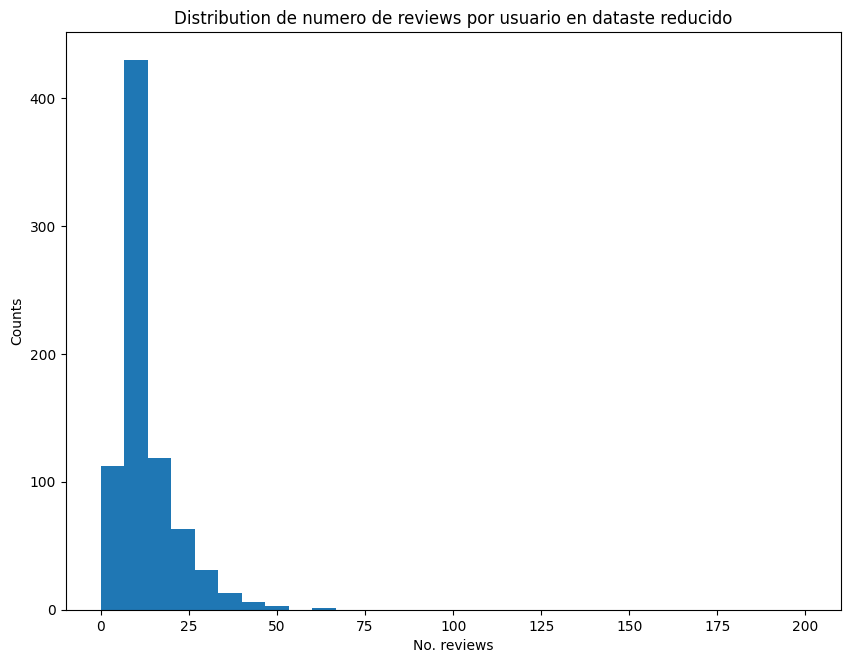

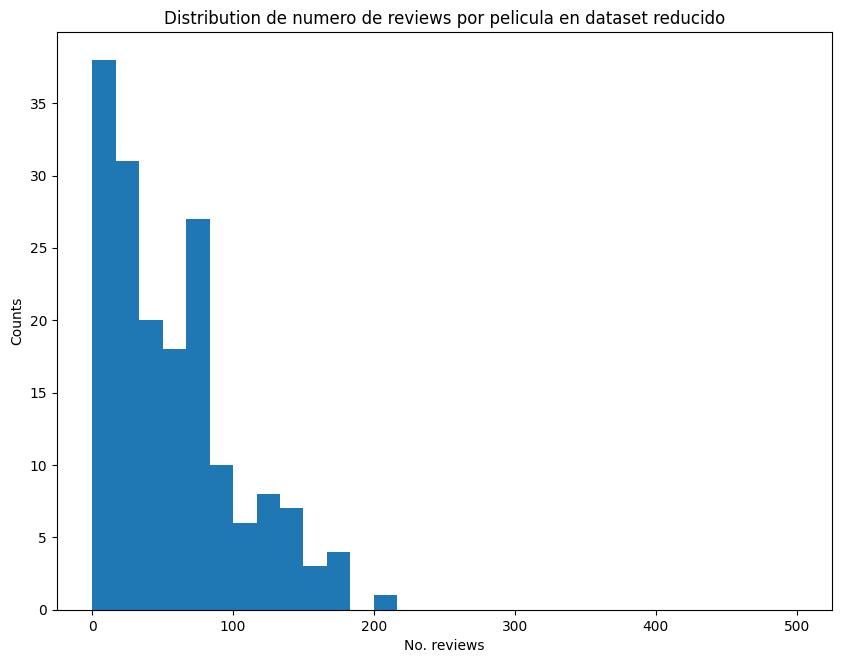

In [36]:
#repeat ex2
myhist( smalldf.groupby("user").size(), 
       "Distribution de numero de reviews por usuario en dataste reducido", "No. reviews", n_bins = 30, range = [0,200] )
myhist( smalldf.groupby("item").size(), 
       "Distribution de numero de reviews por pelicula en dataset reducido", "No. reviews", n_bins = 30, range = [0,500] )

print( "Numero de usuarios es %d." % smalldf.user.unique().size )
print( "Numero de reviews es %d." % smalldf.item.unique().size )

Podemos encontrar que la cantidad de reseñas por usuario se acumula principalmente por debajo de 50, lo que significa que la mayoría de los usuarios no expresan su opinión sobre aproximadamente $\frac{123}{173}\approx 71\%$ películas. En cuanto a la cantidad de reseñas por película, se acumula principalmente por debajo de 200, lo que significa que para la mayoría de las películas no recibe ningún comentario de alrededor de $\frac{578}{778}\approx 74\%$ usuarios. En comparación con el conjunto de datos completo, la escasez se reduce (99,99% a 71% y 74% respectivamente).

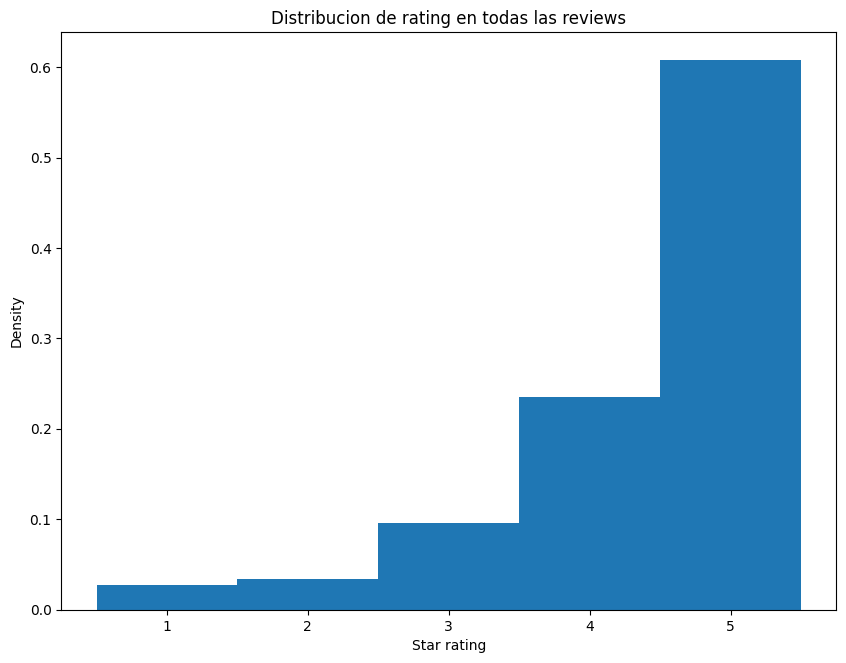

In [37]:
myhist( smalldf.rating, "Distribucion de rating en todas las reviews", "Star rating", 
       n_bins = np.linspace( 0.5, 5.5, num = 6 ), density = True, range = [0,6]  )

La distribución cambió de una 'forma de U' a una distribución unimodal con un máximo de 5 estrellas. Esto se debe a que las películas con más reseñas tienden a ser mejores que las que reciben menos reseñas.

## Primer sistema de recomendacion

Digamos que la calificación promedio de las películas en Amazon es 3.5. *La Comunidad del Anillo* es mejor que la mayoría de las películas, y la calificación promedio es probablemente 1.3 por encima del promedio global (sobre todos los usuarios). Sin embargo, eres bastante estricto al otorgar 5 estrellas a cualquier película y tiendes a calificar todas las películas con 0.5 estrellas por debajo del promedio. Por lo tanto, una estimación de referencia para su calificación de *La comunidad del anillo* es 3.5+1.3-0.5=4.3.

Una estimación de referencia, como la que se ilustra arriba, tiene en cuenta las tendencias sistemáticas de algunos usuarios que otorgan calificaciones más bajas en todos los ámbitos que otros (y viceversa). Podemos escribir la estimación de referencia para una calificación desconocida $\text{Calificación}_{um}$ para el usuario $u$ y la película $m$ como:

$$
\text{Baseline Rating}_{u}(m) = \text{Global average} + \text{Movie deviation}_m + \text{User deviation}_u
$$

donde $\text{Global average}$ es el rating promedio de todas las peliculas para todos los usuario. Los valores $\text{Movie deviation}_m$ y $\text{User deviation}_u$ indican las desviacionesdel user $u$ y el item $m$, del promedio global

Lo más sencillo para empezar, obtener una estimacion de $\text{Movie deviation}_m$ y $\text{User deviation}_u$, es la siguiente:

$$
\text{Movie deviation}_m = \text{Average rating}_m - \text{Global average}\\
\text{User deviation}_u = \text{Average rating}_u - \text{Global average}
$$

Esto está directamente motivado por el ejemplo anterior:  $\text{Movie deviation}_m$ es la desviación de las calificaciones de la película $m$ con respecto a la calificación promedio global y $\text{User deviation}_u$ es la desviación de las calificaciones del usuario. $u$ al rating promedio global.

### Pregunta

Que criticas tienes respecto a este modelo

El siguiente código toma el DataFrame y una ID de usuario y devuelve una lista de estimaciones de referencia de las calificaciones para todas las películas:

In [38]:
def baseline_recommend( df, user ):
    user_mean = df[df.user == user].rating.mean()
    movie_mean = df.groupby('item').rating.mean()
    return user_mean + movie_mean - df.rating.mean()

In [42]:
smalldf.rating.mean()

4.360467824470646

### Ejercicio 2

Hagamos algunas recomendaciones. Enumere las 10 películas con la calificación estimada más alta para el usuario `A101IGU6UDKW3X`, según el conjunto de datos `smalldf`. Tenga en cuenta que puede usar el diccionario `movie_title_dict` para asignar ID de películas a títulos de películas.


In [40]:
user_all_ratings = baseline_recommend( smalldf, 'A10H47FMW8NHII')
user_all_ratings

item
0767853636    4.364400
0782010792    4.910209
0783225857    4.894191
0788802194    4.769858
0788814664    4.455200
                ...   
B004A8ZWVU    4.507128
B004C03TK2    4.312006
B004EPYZCQ    3.401437
B004EPYZUS    4.368104
B004HO6I4M    4.168104
Name: rating, Length: 173, dtype: float64

In [41]:
rating_10 = user_all_ratings.sort_values(ascending = False)[:10]
rating_10.index = [movie_title_dict[x] for x in rating_10.index]
print(rating_10.reset_index())

                                               index    rating
0     Lark Rise To Candleford - Series 3 Region Free  5.068104
1                                          Five Days  5.068104
2                     Curb Your Enthusiasm: Season 8  5.068104
3                                 Wrong Trousers VHS  5.068104
4                               NYPD Blue - Season 1  5.068104
5  24 - Season 5 2006 Kiefer Sutherland; Carlos B...  5.009280
6               Toy Story (Mandarin Chinese Edition)  5.004812
7                                Fiddler on the Roof  4.946891
8                                 The Wire: Season 3  4.934770
9                             My Neighbor Totoro VHS  4.928569


### Pregunta

¿Cómo se puede mejorar la calificación de referencia anterior?

## Un paso más allá: la recomendación global del vecino más cercano

La estimación de referencia que acabamos de implementar es bastante cruda. Esto se debe a que las estimaciones de referencia solo usan información sobre *este* usuario en particular y *esta* película en particular.

Para cualquier usuario dado, podemos hacer un mejor trabajo al recomendar películas que sean similares a las que ya ha visto y que tengan una calificación alta. Esta es realmente la idea del **filtrado colaborativo**: tomar prestada información de otros usuarios y sus preferencias. Este enfoque requiere una medida de similitud para un par de películas. Los candidatos potenciales incluyen [similitud de coseno](http://en.wikipedia.org/wiki/Cosine_similarity), [coeficiente de Pearson](http://en.wikipedia.org/wiki/Pearson_product-moment_correlation_coficient) y otros medidas. Aquí, usaremos el coeficiente de Pearson. Esto mide la tendencia de dos usuarios similares a calificar dos elementos similares de manera similar. Dado que la mayoría de las calificaciones son desconocidas, se calcula en el "grupo de usuarios comunes", que es el conjunto de calificadores comunes de un par de películas.

Analicemos cómo calculamos la similitud con un poco más de detalle. Para dos películas $u$ y $v$, buscamos todos los usuarios que las calificaron y calculamos el coeficiente de Pearson entre esos dos conjuntos de calificaciones. Intuitivamente, si el coeficiente es cercano a 1, estas dos películas tienen méritos similares. Calculamos la similitud entre $u$ y todas las demás películas y seleccionamos las mejores películas de $k$ con los coeficientes de Pearson más altos como candidatas para la recomendación, siempre que al usuario realmente le guste la película $u$.

### Ejercicio 3

Puedes dar criticas a este enfoque

**Respuesta.** El recomendador global tiene la ventaja de abordar el problema de los datos faltantes en el conjunto de datos original, pero puede ser demasiado rígido en el sentido de que no tiene en cuenta las preferencias personales de los usuarios. Además, si solo hay una pequeña cantidad de usuarios comunes (por ejemplo, 2), la correlación no es confiable, ya que podría no reflejar una tendencia general.

Implementemos el sistema global de recomendacion paso a paso

### Ejercicio 4

Escriba una función para encontrar los usuarios comunes que calificaron tanto `mov1` como `mov2`. La entrada de esta función debe ser el conjunto de datos y las dos ID de película. Esta función debería devolver una lista de ID de usuario que revisaron ambas películas. Utilice esta función para trazar un histograma de la distribución del número de revisores comunes para todos los pares de películas según `smalldf`. ¿Cuál es el número promedio de revisores comunes?

In [43]:
def find_ncommon(df, mov1, mov2):
    u1 = df[df.item==mov1].user
    u2 = df[df.item==mov2].user
    ucom = np.intersect1d(u1, u2)
    return ucom

In [51]:
from itertools import combinations
for i,x in enumerate(combinations(smalldf.item.unique(),2)):
    if i<=5:
        print(i,x)
    else:
        pass

0 ('0767853636', '0790729628')
1 ('0767853636', '0792158202')
2 ('0767853636', '6300213986')
3 ('0767853636', '6304176287')
4 ('0767853636', '6305132666')
5 ('0767853636', '6305265496')


In [52]:
from itertools import combinations
# IMPORTANTE: EL ORDEN NO IMPORTA ACA , es decir A,B si ya existe no se considera B,A
ncom_dist = [len(find_ncommon(smalldf, pair[0], pair[1])) for pair in combinations(smalldf.item.unique(),2)]

Promedio comun: 5.535421427611238


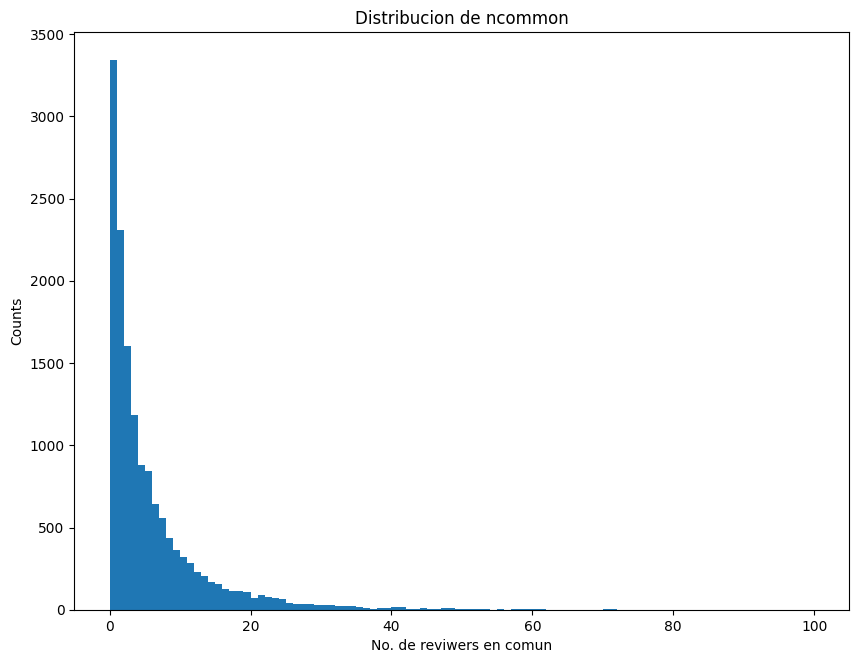

In [53]:
myhist( ncom_dist, title = "Distribucion de ncommon", xlab = "No. de reviwers en comun" )
print("Promedio comun:", np.mean(ncom_dist))

Como puede ver, aunque elegimos un subconjunto del DataFrame en el que cada película tenía al menos 1000 reseñas y cada usuario había reseñado al menos 100 películas, la cantidad de revisores comunes de la mayoría de los pares de películas es bastante baja. Ahora escribamos una función para calcular la similitud entre dos películas, en función de sus revisores comunes:

### Ejercicio 5

Use la función `personr` de `scipy.stats.stats` para calcular la similitud entre dos películas. Si dos películas no tienen un revisor en común o solo un revisor común, establezca el valor predeterminado en cero. Si uno o ambos vectores de calificación tienen varianza cero, dejamos que sea `nan`, la salida predeterminada de `pearsonr`. Esta función debe tomar tres entradas, un DataFrame y dos ID de película. Esta función debería devolver el coeficiente de Pearson junto con el número de revisores comunes en una tupla. Con esta función, calcule la similitud entre las películas `0767853636` y `0790729628`.

In [54]:
from scipy.stats.stats import pearsonr
def pearson_sim(df, mov1, mov2):
    ucommon = find_ncommon(df, mov1, mov2)
    if len(ucommon)<2:
        rho=0.
    else:
        mov1_df = df[(df.item==mov1)&(df.user.isin(ucommon))]
        mov2_df = df[(df.item==mov2)&(df.user.isin(ucommon))]
        mov1_score = mov1_df.rating - mov1_df.user_mean  ## importante quitar la media
        mov2_score = mov2_df.rating - mov2_df.user_mean  ## importante quitar la media
        rho=pearsonr(mov1_score, mov2_score,)[0]
    return (rho, len(ucommon))

In [56]:
sim_res = pearson_sim( smalldf, '0767853636', '0790729628')
print("Similitud entre dos peliculas:", sim_res[0], "\nNo. de reviewers en comun:", sim_res[1])

Similitud entre dos peliculas: 0.8217358967111834 
No. de reviewers en comun: 4


El valor absoluto de la calificación no es directamente comparable entre usuarios. Esto se debe a que las personas tienden a tener diferentes criterios al dar puntajes, incluso si la calificación general de una película es similar. Nuestra solución a esto es extraer la puntuación media del usuario de la puntuación de una película específica antes de calcular el coeficiente de Pearson. 

Para acelerar el cálculo de las siguientes secciones de este caso, ahora escribimos una función `pearson_sim` para construir un marco de datos de similitud por pares entre películas en `smalldf`. La clave es la forma de `mov1|mov2` donde `mov1` y `mov2` están en orden alfabético:


In [57]:
def pearson_sim_dict( df ):
    ret_dict = {}
    for mov1, mov2 in combinations(df.item.unique(), 2):
        key = "|".join(sorted([mov1, mov2]))
        ret_dict[key] = pearson_sim( df, mov1, mov2 )
    return ret_dict

In [58]:
psim_dict = pearson_sim_dict(smalldf)

In [60]:
[(key, value) for i, (key, value) in enumerate(psim_dict.items()) if i < 5]

[('0767853636|0790729628', (0.8217358967111834, 4)),
 ('0767853636|0792158202', (0.18360811486265444, 4)),
 ('0767853636|6300213986', (-0.995431273244007, 3)),
 ('0767853636|6304176287', (-0.21402947766557798, 8)),
 ('0767853636|6305132666', (0.9833931566973749, 3))]

### $k$ - nearest movies 

Ahora vamos a encontrar las $k$ películas más similares a una película dada usando la medida de similitud que implementamos arriba en `pearson_sim`. Podemos usar directamente la salida de `pearson_sim`, pero si la cantidad de revisores comunes para un par de películas es pequeña (por ejemplo, digamos que solo hay dos revisores comunes), es muy probable que la similitud se deba al gusto individual de uno. de los revisores y, por lo tanto, no necesita reflejar una tendencia general. Para superar esto, presentamos un enfoque de regularización para reducir la salida de `pearson_sim` en función del tamaño del conjunto de revisores comunes:

$$ sim_{ij} = \frac{N_{common}}{N_{common}+reg} \, \rho^\text{Pearson} _{ij}$$

donde $N_{common}$ es el tamaño del conjunto de revisores comunes y and $\rho^\text{Pearson}_{ij}$ es el Pearson correlation coefficient entre las peliculas $i$ y $j$.

En términos generales, la regularización anterior lleva la estimación de similitud hacia un punto conservador (0). La fuerza de la contracción disminuye a medida que aumenta el número de revisores comunes. Dado que creemos que 10 revisores comunes son una fuente de información relativamente confiable, podemos establecer `reg` en 3. La función `shrunk_sim` que toma `sim` y `n_common` de la salida de `pearson_sim` calcula la similitud regularizada .

In [61]:
def shrunk_sim(sim, n_common, reg=3.):
    ssim=(n_common*sim)/(n_common+reg)
    return ssim

### Ejercicio 6

Escribamos una función para encontrar las $k$ - películas más cercanas a una película dada `mov`. La entrada de esta función debe ser un DataFrame de reseñas, una ID de película `mov`, una lista de películas candidatas `mov_list`, el diccionario de similitud `sim_dict`, el valor de $k$ y la fuerza de la reducción `reg`. El resultado debe ser una lista ordenada de las $k$ películas similares principales a `mov`, ordenadas por similitud regularizada. Cada elemento de esta lista debe contener la identificación de la película, la similitud regularizada y la cantidad de revisores comunes.

In [62]:
def knearest( df, mov, mov_list, sim_dict, k = 7, reg = 3. ):
    allsim = []
    for movid in mov_list:
        if movid != mov:
            key = "|".join(sorted([mov, movid]))
            sim_raw = sim_dict[key]
            ssim = shrunk_sim(sim_raw[0], sim_raw[1], reg)
            allsim.append([movid, ssim, sim_raw[1]])
    return sorted( allsim, key = lambda x: x[1], reverse = True )[:k]

Ahora, usemos esta función para encontrar los 7 vecinos más cercanos de la película `B001AVCFJM` y `6304176287`. Debe usar el diccionario `movie_title_dict` para obtener los títulos reales de todas las películas seleccionadas.

In [64]:
tops=knearest( smalldf, 'B001AVCFJM', smalldf.item.unique(), psim_dict )
print("Para ", movie_title_dict['B001AVCFJM'], ", los top matches son:")
for i, (movid, sim, nc) in enumerate(tops):
    print(i, movie_title_dict[movid], "| Sim", sim, "| Common Reviewers",nc)

Para  Star Trek , los top matches son:
0 The Walking Dead: Season 1 | Sim 0.6328322148036967 | Common Reviewers 13
1 The NeverEnding Story VHS | Sim 0.6249999999999999 | Common Reviewers 5
2 Alien: Quadrilogy (Alien / Aliens / Alien 3 / Alien Resurrection) | Sim 0.596146546956422 | Common Reviewers 15
3 The Wire: Season 3 | Sim 0.5691293751464974 | Common Reviewers 6
4 My Neighbor Totoro VHS | Sim 0.5671611503687135 | Common Reviewers 13
5 Jane Austen's Pride and Prejudice Six Piece Collector's VHS | Sim 0.5 | Common Reviewers 3
6 24 - Season 7 2009 Kiefer Sutherland; Cherry Jones | Sim 0.4772363487628477 | Common Reviewers 5


In [65]:
tops2=knearest( smalldf, '6304176287', smalldf.item.unique(), psim_dict)
print("Para ", movie_title_dict['6304176287'], ", los top matches son:")
for i, (movid, sim, nc) in enumerate(tops2):
    print(i, movie_title_dict[movid], "| Sim", sim, "| Common Reviewers",nc)

Para  Willy Wonka & the Chocolate Factory VHS , los top matches son:
0 The Boy in the Striped Pajamas | Sim 0.6249999999999999 | Common Reviewers 5
1 The Boy in the Striped Pajamas | Sim 0.6249999999999999 | Common Reviewers 5
2 Amelie | Sim 0.5856313568488608 | Common Reviewers 7
3 Christmas Collector's Pack The Bells of St. Mary's / It's a Wonderful Life | Sim 0.5121754427091352 | Common Reviewers 16
4 The Blind Side L'Eveil d'un champion | Sim 0.5 | Common Reviewers 3
5 Moodtapes: Pacific Surf | Sim 0.5 | Common Reviewers 3
6 Airplane VHS | Sim 0.4968073841402392 | Common Reviewers 9


Podemos ver que las películas más similares, según las calificaciones de los críticos comunes, tienen cierta semejanza con la película objetivo.

### Ejercicio 7

Escriba una función para encontrar primero las películas 'k1' principales que un usuario calificó y luego busque todas las películas que son las vecinas más cercanas 'k2' de estas películas mejor calificadas, pero que el usuario aún no ha visto. La entrada de esta función es un dataframe revisiones, una identificación de usuario, un diccionario de similitud y los valores de `k1` y `k2`. El resultado es una lista y cada elemento de ella es otra lista que contiene el título de la película y su calificación promedio entre todos los revisores. La salida debe ordenarse por las calificaciones promedio de mayor a menor.


In [66]:
def recommend_global(df, user, sim_dict, k1 = 5, k2 = 7, reg = 3.):
    df_user = df[df.user==user]
    all_mov = df.item.unique()
    user_top = df_user.sort_values(by=['movie_mean'], ascending=False).item[:k1]
    
    rec_mov = []
    for mov in user_top:
        rec_list = [x[0] for x in knearest( df, mov, all_mov, sim_dict, k = k2, reg=reg )]
        rec_mov = np.union1d(rec_mov, rec_list)
    
    #remove las peliculas que ya ha visto
    rec_mov = np.setdiff1d(rec_mov, user_top)
    mean_ratings = df[df.item.isin(rec_mov)].groupby('item').first()['movie_mean']
    
    rec_mov_res = [[rec_mov[i], mean_ratings[i]] for i in range(len(rec_mov))]
    return sorted( rec_mov_res, key = lambda x: x[1], reverse = True )

Ahora usemos `recommend_global` para hacer recomendaciones para el usuario `A101IGU6UDKW3X`. Seteamos `k1=5`, `k2=7` y `reg=3.0`.

In [67]:
res = recommend_global( smalldf, 'A101IGU6UDKW3X', psim_dict, k1 = 5, k2 = 7, reg = 3.0)
print("Recomendacion para el user A101IGU6UDKW3X:")
for mov, rate in res:
    print(movie_title_dict[mov], "|", np.round(rate,2))

Recomendacion para el user A101IGU6UDKW3X:
Christmas Collector's Pack The Bells of St. Mary's / It's a Wonderful Life | 4.81
My Neighbor Totoro VHS | 4.8
To Kill a Mockingbird | 4.77
The X-Files - The Complete First Season | 4.76
The Lord of the Rings: The Return of the King | 4.72
The Incredibles (Mandarin Chinese Edition) | 4.67
Alien: Quadrilogy (Alien / Aliens / Alien 3 / Alien Resurrection) | 4.67
White Christmas VHS | 4.63
White Christmas | 4.63
A Christmas Story VHS | 4.62
The Blind Side L'Eveil d'un champion | 4.61
Amelie | 4.57
The Magnificent Seven VHS | 4.53
Up (Mandarin Chinese Edition) | 4.53
Moodtapes: Pacific Surf | 4.5
Batman Begins | 4.48
Terminator, The | 4.47
The Boy in the Striped Pajamas | 4.45
The Boy in the Striped Pajamas | 4.45
Secondhand Lions | 4.38
The Lord Of The Rings: Trilogy | 4.33
Red | 4.24
The Spiderwick Chronicles Field Guide Edition | 4.0


## Un recomendador de vecinos más cercanos basado en el usuario con calificaciones previstas

Ahora podemos proporcionar recomendaciones basadas en similitudes globales. Sin embargo, en muchos casos esto no es suficiente.

Por ejemplo, es difícil juzgar si las recomendaciones anteriores son buenas. Tenga en cuenta que, hasta ahora, solo hacemos recomendaciones, pero no estimamos la calificación que el usuario le daría a la película recomendada. En esta sección, cambiamos nuestro enfoque para predecir qué _calificación_ le daría un usuario a una película que nunca ha visto antes. Para ello, aprovecharemos la información de las películas que el usuario haya puntuado.

Para ser más específicos, ahora modificaremos la estimación de referencia de calificación por la siguiente especificación:


$$ \text{Rating}_{u}(m) = \text{Baseline Rating}_{u}(m)\, + \,\frac{\sum\limits_{j \in S(k)} sim_{mj} ( \text{Rating given by the user}_{u}(j) - \text{Baseline Rating}_{u}(j) )}{\sum\limits_{j \in S(k)} sim_{mj} } $$

donde $S(k)$ son las $k$ películas vecinas de la película $m$ que han sido calificadas por el usuario $u$ y $sim_{mj}$ es la similitud entre la película $m$ y la película $j$. La idea aquí es acercar la estimación de la calificación de la película $u$ a las calificaciones observadas de las películas que son "similares" a ella.

Ahora escribimos una función `knearest_userrated`, análoga a la función `knearest` que definimos anteriormente, para encontrar los vecinos `k` más cercanos a una película dada de las **películas que el usuario ya ha calificado**. Esta función tomará como argumentos el DataFrame de reseñas, `mov_id`, `user_id`, `sim_dict`, `k`, y el regularizador `reg`. Al igual que antes, devolvemos una *lista ordenada de k-longitud* de 3 tuplas, cada una correspondiente a una película:

In [68]:
def knearest_userrated( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    return knearest( df, mov_id, df[df.user == user_id].item, sim_dict, reg = reg, k = k )

Ahora escribamos una función que devuelva la calificación prevista para un usuario y una película usando la fórmula al comienzo de esta sección. Si la suma de las puntuaciones que van en el denominador es 0, devolveremos una calificación predicha de la parte de referencia de la fórmula en ese caso. Además, si la calificación estimada es menor que 0, establecemos que sea 0 y si la calificación estimada es mayor que 5, establecemos que sea 5. Esta función 'calificación' toma como argumentos el marco de datos de revisión, `mov_id` y `user_id` de interés, diccionario de similitud `sim_dict` y `k` así como el regularizador:


In [69]:
def rating( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    # separar en tres campos de la salida de knearest_userrated
    id_k, sim_k, sup_k = map( list, zip( *knearest_userrated( df, mov_id, user_id, sim_dict, reg = reg, k = k ) ) )
    
    #calcular el baseline
    baseline_all = baseline_recommend(df, user_id)
    obs = df[(df.user==user_id)&(df.item.isin(id_k))].rating
    
    rating_adj = baseline_all[mov_id] + np.dot(np.array(obs) - np.array(baseline_all[id_k]), sim_k)/np.sum(sim_k)
    
    #tratar el caso cuando el denominador es cero
    if np.abs(np.sum(sim_k))<1e-3:
        rating_adj = 0
    #borrar los nan
    if np.isnan(rating_adj):
        rating_adj = 0
    
    return rating_adj

Ahora usemos la función `ratinf` para predecir la calificación del usuario `A101IGU6UDKW3X` para las películas recomendadas por el recomendador global en el Ejercicio 7:

In [70]:
print("User Average", smalldf[smalldf.user=='A101IGU6UDKW3X'].rating.mean(),"para el User", 'A101IGU6UDKW3X')
print("Ratings predichos para las top choices calculadas previamente:")
for mov_id, mov_score in res:
    print(movie_title_dict[mov_id],"|",np.round(rating(smalldf, mov_id, 'A101IGU6UDKW3X', psim_dict, k=7, reg=3.),2),"|","Average", np.round(mov_score,2))

User Average 4.473684210526316 para el User A101IGU6UDKW3X
Ratings predichos para las top choices calculadas previamente:
Christmas Collector's Pack The Bells of St. Mary's / It's a Wonderful Life | 4.83 | Average 4.81
My Neighbor Totoro VHS | 5.31 | Average 4.8
To Kill a Mockingbird | 4.93 | Average 4.77
The X-Files - The Complete First Season | 4.96 | Average 4.76
The Lord of the Rings: The Return of the King | 4.77 | Average 4.72
The Incredibles (Mandarin Chinese Edition) | 4.71 | Average 4.67
Alien: Quadrilogy (Alien / Aliens / Alien 3 / Alien Resurrection) | 4.95 | Average 4.67
White Christmas VHS | 5.17 | Average 4.63
White Christmas | 5.16 | Average 4.63
A Christmas Story VHS | 5.12 | Average 4.62
The Blind Side L'Eveil d'un champion | 0 | Average 4.61
Amelie | 4.72 | Average 4.57
The Magnificent Seven VHS | 4.76 | Average 4.53
Up (Mandarin Chinese Edition) | 4.7 | Average 4.53
Moodtapes: Pacific Surf | 4.8 | Average 4.5
Batman Begins | 4.92 | Average 4.48
Terminator, The | 4.85

Tenga en cuenta que la calificación promedio global para estas películas no tiene el mismo orden que la calificación prevista para este usuario. Esto indica que se hace una recomendación personalizada utilizando la función `rating`.

## Error analysis of the predicted ratings (15 min)

Let's compare the predicted ratings with a user's actual ratings. Ideally, we should conduct cross-validation and estimate the rating for every review in the dataset using an external dataset. But since the dataset is rather large, cross-validation would be very time-consuming. For illustrative purposes, we will split `smalldf` into a test and a training set and proceed from there.

### Ejercicio 8

Divida `smalldf` en conjuntos de entrenamiento y prueba donde el conjunto de entrenamiento contenga el 90% de las revisiones. Prediga las calificaciones de las revisiones en el conjunto de prueba y use la función `compare_results` (que se proporciona a continuación) para comparar las calificaciones pronosticadas y las calificaciones reales. Examine tres escenarios: 
- `k=3, reg=3`
- `k=3, reg=15`
- `k=10, reg=3`.


In [71]:
def compare_results(rating_actual, rating_predicted, ylow=-10, yhigh=15, title=""):
    from sklearn.metrics import mean_squared_error
    fig=plt.figure()
    df=pd.DataFrame(dict(actual=rating_actual, predicted=rating_predicted))
    ax=plt.scatter(df.actual, df.predicted, alpha=0.2, s=30, label="predicted")
    plt.ylim([ylow,yhigh])
    plt.plot([1,5],[1,5], label="slope 1")
    df_mean=df.groupby('actual').predicted.mean().reset_index()
    df_sig=df.groupby('actual').predicted.std().reset_index()
    
    # only plot means with variance estimate
    df_mean = df_mean[~np.isnan(df_sig.predicted)]
    df_sig = df_sig[~np.isnan(df_sig.predicted)]
    plt.plot(df_mean['actual'], df_mean['predicted'],'k', label="means")
    plt.fill_between(df_sig['actual'], df_mean['predicted']-df_sig['predicted'],
                     df_mean['predicted']+df_sig['predicted'], color='k', alpha=0.2)
    
    plt.xlabel("actual")
    plt.ylabel("predicted")
    plt.legend(frameon=False)
    plt.grid(False)
    plt.title(title)
    print("MSE:", mean_squared_error(rating_actual, rating_predicted))

In [72]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(smalldf, shuffle = True, test_size = 0.1, random_state = 2)
sim_dict = pearson_sim_dict( train )

MSE: 4.760233607079899


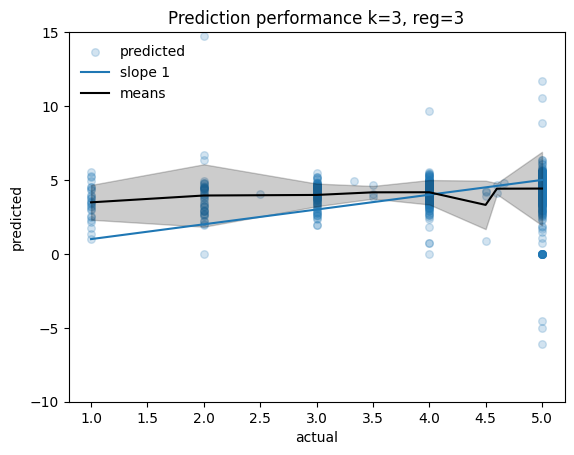

In [73]:
predict = [rating(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=3" )

MSE: 5.137443955567251


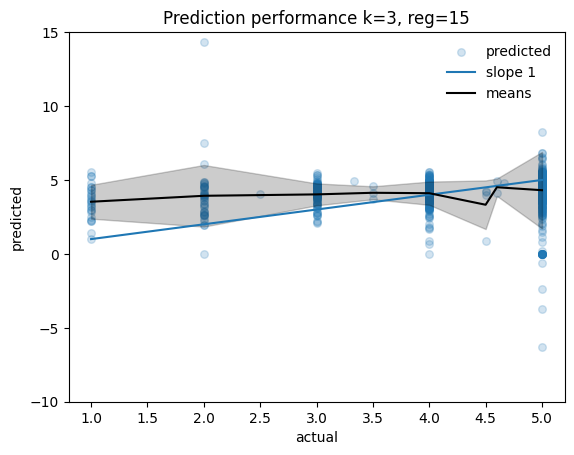

In [74]:
predict = [rating(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=15.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=15" )

MSE: 113.08492380223288


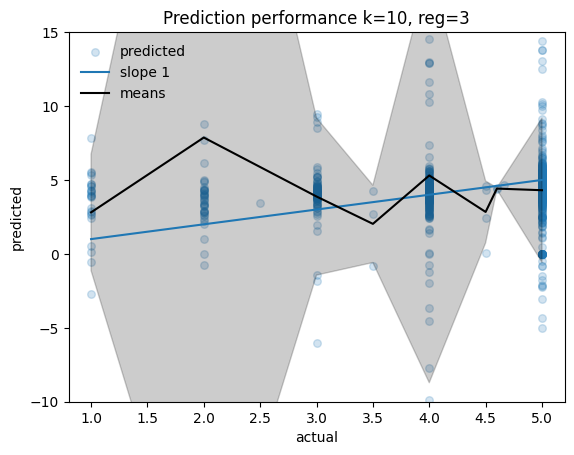

In [75]:
predict = [rating(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=10, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=10, reg=3" )

Los cuatro gráficos anteriores muestran cuán precisas son nuestras predicciones. Si las predicciones son 100% precisas, todos los puntos deben estar en la línea de pendiente 1. En nuestro caso, esto no es posible debido a la simplicidad del modelo. De esta forma obtenemos una banda de puntos que corresponden a cada calificación real. Cuanto más estrecha es la banda, mayor es la precisión de la predicción. La línea azul que está formada por la media de predicción puede ofrecernos un sesgo estimado para la predicción. La banda gris también se usa para mostrar precisión.

Las diferencias en las tres graficas nos dicen que usar un número menor de vecinos más cercanos puede ayudar a mejorar la precisión de la predicción. Esto es intuitivamente correcto porque los elementos que son similares deberían ser mucho más informativos que los elementos menos similares para la predicción. El parámetro de regularización no tiene un efecto claro en la predicción. Comparando las tres configuraciones, preferiríamos el modelo con 3 vecinos más cercanos y parámetro de regularización 3.

También hay una observación bastante interesante. El sesgo de la predicción parece ser muy pequeño cuando el puntaje real es de alrededor de 4 y relativamente mayor cuando el puntaje se acerca a 1 y 5. Esto tiene sentido intuitivo ya que los puntos reales extremos pueden ser valores atípicos y hacer que el modelo funcione peor, mientras que cuando el está en un rango moderado, podría ser más robusto para el modelo que estamos usando.

### Limitación de las estimaciones de las calificaciones para una varianza más pequeña 

Como podemos ver, las varianzas de las estimaciones del enfoque de similitud son bastante grandes. La razón principal es que muchas estimaciones son mayores que 5 o menores que 0, que están fuera del rango de las calificaciones reales. Podemos reducir la varianza limitando las estimaciones para que estén entre 0 y 5. Lo implementamos en `rating_cap`:


In [76]:
def rating_cap( df, mov_id, user_id, sim_dict, reg, k = 7 ):
    # separar los tres campos de knearest_userrated
    id_k, sim_k, sup_k = map( list, zip( *knearest_userrated( df, mov_id, user_id, sim_dict, reg = reg, k = k ) ) )
    
    #calcular el baseline
    baseline_all = baseline_recommend(df, user_id)
    obs = df[(df.user==user_id)&(df.item.isin(id_k))].rating
    
    rating_adj = baseline_all[mov_id] + np.dot(np.array(obs) - np.array(baseline_all[id_k]), sim_k)/np.sum(sim_k)
    
    #tratar cuando el denominador es cero
    if np.abs(np.sum(sim_k))<1e-3:
        rating_adj = 0
    #deshacernos de los nan
    if np.isnan(rating_adj):
        rating_adj = 0
    
    if rating_adj<0:
        rating_adj = 0
    if rating_adj>5:
        rating_adj = 5
    
    return rating_adj

Hacemos los mismos analisis

MSE: 1.500673653026886


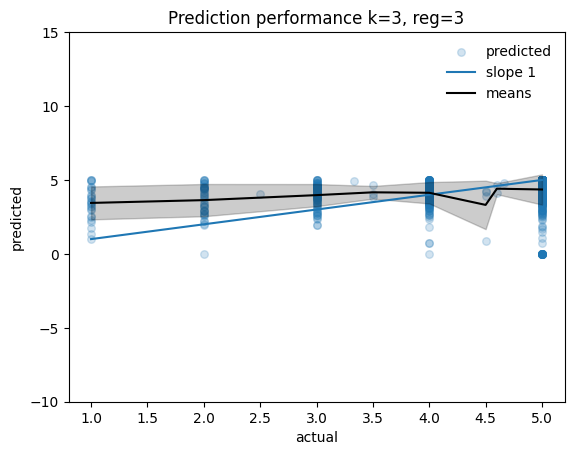

In [77]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=3" )

MSE: 1.572254365234287


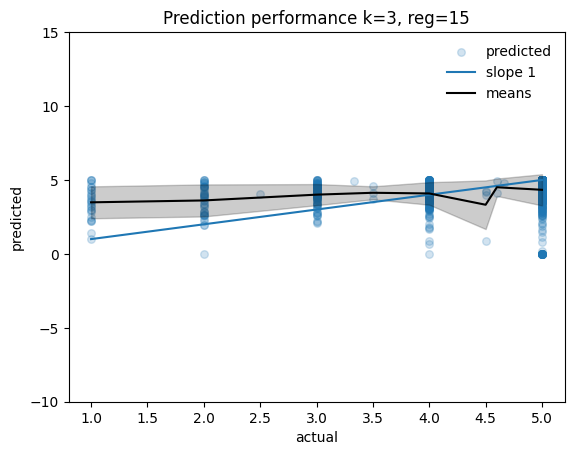

In [78]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=3, reg=15.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=3, reg=15" )

MSE: 2.199468758727016


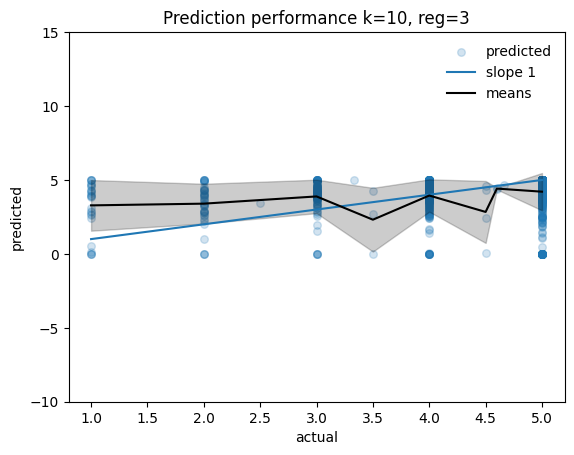

In [79]:
predict = [rating_cap(train, test.item.iloc[i], test.user.iloc[i], sim_dict, k=10, reg=3.) for i in range(test.shape[0])]
compare_results( test.rating, predict, title = "Prediction performance k=10, reg=3" )

Está claro que después de la limitación, el MSE general se reduce significativamente. Sin embargo, también encontramos, con base en las cifras, que las calificaciones estimadas tienden a tener un mayor sesgo, como lo refleja la desviación de las curvas negras a la curva azul en cada figura. Esto ilustra el equilibrio típico entre sesgo y varianza.

## Latent factor based recommendations: nonnegative matrix factorization

Procedamos ahora a usar un enfoque basado en factores latentes para construir un sistema de recomendación. La forma de extraer estos factores latentes es la **factorización matricial no negativa (NMF)**.

### The latent factor model 

#### Model overview

La idea central en la construcción de un sistema de recomendación usando filtrado colaborativo es que *usuarios similares calificarán películas similares de manera similar*. En las secciones anteriores, implementamos explícitamente esta idea usando la medida de similitud. También asumimos que todos los usuarios eran iguales (el enfoque global) o que solo el usuario actual era lo suficientemente similar para hacer una recomendación (el enfoque específico del usuario). En esta sección, utilizaremos un modelo que nos permite identificar usuarios similares y películas similares en función de **factores latentes**.

Podemos pensar en los factores latentes como propiedades de las películas (p. ej., género, precio, duración) por las que los usuarios tienen una preferencia positiva o negativa. No observamos estos factores o las preferencias de los usuarios directamente, pero asumimos que afectan la forma en que los usuarios tienden a calificar las películas. Por ejemplo, una película extremadamente larga recibiría una calificación baja si el crítico prefiere títulos de ritmo rápido. Tenga en cuenta que si los usuarios tienen preferencias similares, de acuerdo con el modelo, se comportarán de manera similar y, de la misma manera, si las películas tienen factores latentes similares, serán calificadas de manera similar por usuarios similares.

Un problema que surge con los modelos de factores latentes es determinar cuántos factores latentes incluir. Podemos tratar el problema de elegir el número de factores latentes con validación cruzada.


#### Rating model specification

Denotemos la calificación real de la película $m$ del usuario $u$ como $Y_{um}$. En nuestro conjunto de datos, tenemos $N$ usuarios distintos y $M$ películas distintas. No todas las combinaciones de películas y usuarios tienen calificaciones. Asumimos que hay $L$ reseñas en total. El modelo de factor latente que especificamos asume que cada película está asociada con un factor latente $K$ dimensional $v_m$ y cada usuario está asociado con un factor latente $K$ dimensional $w_u$. Además, suponemos que:

$$
Y_{um} = v_m^\intercal w_u
$$

Tenga en cuenta que según la especificación de este modelo, si dos películas tienen $v_m$ muy similares, la puntuación asociada $Y$ de cualquier usuario debería ser similar. Y si dos usuarios tienen $w_u$ muy similares, sus calificaciones para cualquier película también deberían ser muy similares. La siguiente figura proporciona un resumen muy claro de la especificación del modelo:

![](factor_model.png)
*Image from this [website](https://medium.com/@connectwithghosh/simple-matrix-factorization-example-on-the-movielens-dataset-using-pyspark-9b7e3f567536)*

#### Estimacion para este modelo

Usando este modelo, queremos estimar $v$ y $w$ para todos los usuarios y todas las películas, antes de lo cual también es importante determinar $K$. Existen numerosas formas de estimar estas cantidades, pero en esta sección nos centraremos en la factorización de matriz no negativa (NMF). La idea de este enfoque es que tanto $w$ como $v$ deben ser vectores no negativos. Esta restricción hace que la predicción para cualquier revisión no observada no sea negativa y desalienta las calificaciones previstas extremadamente altas, que es la principal ventaja del enfoque NMF en comparación con el enfoque que presentamos anteriormente.

No importa cuál sea la implementación de la factorización matricial que estemos usando, el objetivo final en la estimación es aproximar las calificaciones observadas lo más cerca posible. Esto generalmente se logra minimizando el error cuadrático medio de las calificaciones previstas para las revisiones que están disponibles en el conjunto de datos de capacitación.

Proporcionamos la función `recommend_nmf` basada en el paquete `surprise` para predecir las calificaciones de un usuario específico para una película específica. La entrada es un DataFrame de revisiones y el número de factores latentes. La salida es un objeto `algo` ajustado:

In [3]:
!pip install scikit-surprise

Defaulting to user installation because normal site-packages is not writeable
                                              0.0/772.0 kB ? eta -:--:--
     ----------------                       327.7/772.0 kB 6.8 MB/s eta 0:00:01
     -------------------------------------- 772.0/772.0 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp39-cp39-win_amd64.whl size=1142292 sha256=099132e9c0105768b54b69375c3d3d96ab90bd72ce7961443b6206b4113de0e9
  Stored in directory: c:\users\windows\appdata\local\pip\cache\wheels\c6\3a\46\9b17b3512bdf283c6cb84f59929cdd5199d4e754d596d22784
Successfully built scikit-surprise


In [80]:
def recommend_nmf(df, K):
    from surprise import NMF
    from surprise import Reader, Dataset
    
    reader = Reader()
    data = Dataset.load_from_df(df[['user', 'item', 'rating']], reader)
    trainset = data.build_full_trainset()
    algo = NMF(n_factors=K)
    algo.fit(trainset)
    return algo

In [81]:
from surprise import NMF
from surprise import Reader, Dataset

### Ejercicio 9

Usando `recommend_nmf` para estimar las calificaciones de las revisiones en `test` basadas en `train` en el Ejercicio 8. Visualice los resultados como en el Ejercicio 8 para `K=5`, `K=20`, `K=50`. Según los resultados, ¿prefiere el método NMF o el método del vecino más cercano?

MSE: 1.5069473065589585


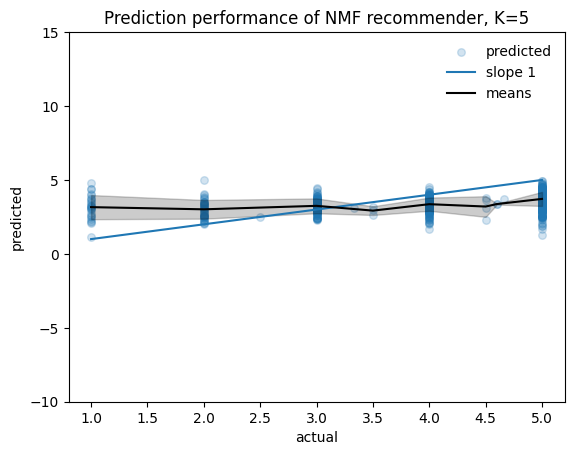

In [82]:
# K=5
rec_K5 = recommend_nmf(train, K=5)
pred_K5 = [rec_K5.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
compare_results( test.rating, pred_K5, title = "Prediction performance of NMF recommender, K=5" )

MSE: 0.856972886097187


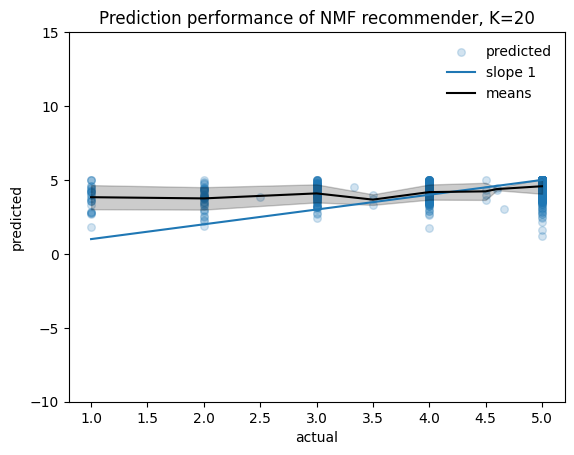

In [83]:
# K=20
rec_K20 = recommend_nmf(train, K=20)
pred_K20 = [rec_K20.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
compare_results( test.rating, pred_K20, title = "Prediction performance of NMF recommender, K=20" )

MSE: 0.9739997268931013


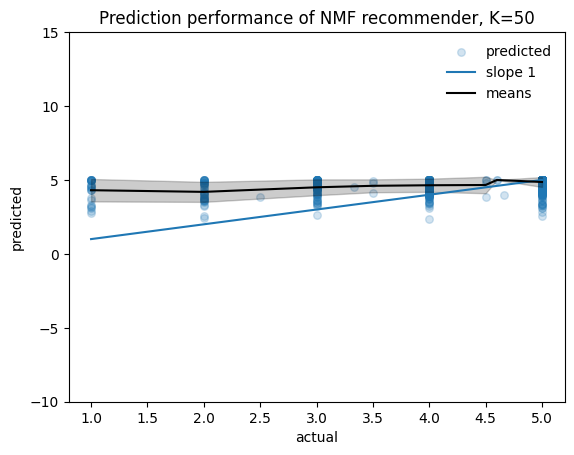

In [84]:
# K=50
rec_K50 = recommend_nmf(train, K=50)
pred_K50 = [rec_K50.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
compare_results( test.rating, pred_K50, title = "Prediction performance of NMF recommender, K=50" )

A partir de los resultados encontramos que NMF logra el MSE más pequeño con $K=20$. También encontramos que la varianza de los valores predichos de NMF es mucho menor que la del método del vecino más cercano; esto se debe principalmente a la restricción de no negatividad. Incluso si llevamos a cabo la reducción de la varianza en el método del vecino más cercano mediante la limitación, el MSE más pequeño en el conjunto de prueba que observamos sigue siendo mayor que el del modelo NMF con mejor desempeño. Además, el costo computacional de NMF es mucho menor que el del enfoque del vecino más cercano, ya que NMF no requiere una matriz de similitud por pares. Con base en estas observaciones, favorecemos el enfoque NMF sobre el enfoque del vecino más cercano.

Sin embargo, NMF aún no puede resolver los problemas de nuevos usuarios/elementos y, en general, el sesgo de los valores predichos es mayor que en el enfoque del vecino más cercano debido a una compensación de varianza de sesgo.


### Efecto de $K$ en la precisión de la predicción

Para visualizar mejor el efecto de $K$ en la precisión de la predicción de las calificaciones, representamos el MSE como una función de $K$:

In [85]:
from sklearn.metrics import mean_squared_error
mse_all = []

for K in range(2,51):
    rec_K = recommend_nmf(train, K=K)
    pred_K = [rec_K.predict(test.user.iloc[i], test.item.iloc[i]).est for i in range(test.shape[0])]
    mse_all.append(mean_squared_error(test.rating, pred_K))

Text(0.5, 1.0, 'Accuracy del NMF model cuando K cambia')

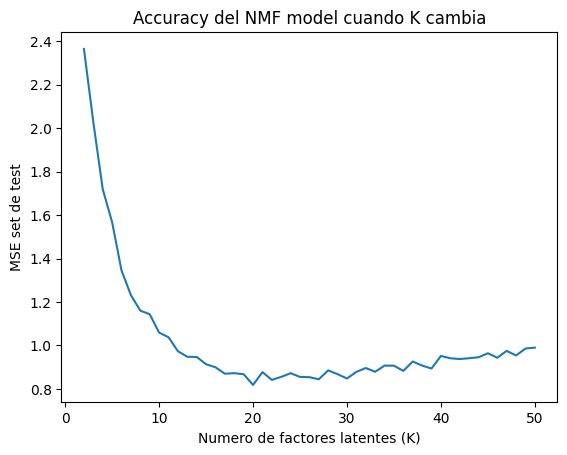

In [86]:
plt.plot(range(2,51), mse_all);
plt.xlabel("Numero de factores latentes (K)");
plt.ylabel("MSE set de test");
plt.title("Accuracy del NMF model cuando K cambia")

Cuando $K$ aumenta, el modelo ajusta los datos con mayor precisión. Sin embargo, esto no implica directamente que la precisión de predicción del modelo entrenado también aumentará cuando se evalúe en un conjunto de prueba externo. La curva que mostramos arriba muestra que si $K$ es demasiado grande ($>20$), el MSE del conjunto de prueba en realidad aumenta, lo que indica un ajuste excesivo del modelo a los datos de entrenamiento. Esta gráfica puede servir como una forma de seleccionar $K$ en la práctica.

## Conclusiones

En este estudio de caso, construimos sistemas de recomendación para películas basados únicamente en datos de reseñas. Nuestro primer recomendador examinó la correlación entre reseñas de revisores comunes y usó la correlación para asignar similitudes entre películas. También introdujimos un sistema de recomendación alternativo construido al descomponer directamente la matriz elemento-usuario en factores latentes de baja dimensión y usamos los factores latentes identificados para estimar la calificación de un usuario para una película aún no vista. Al ordenar la calificación estimada, se puede generar una lista de elementos recomendados.

Encontramos que el primer enfoque tiende a tener un sesgo más bajo pero una varianza más alta, mientras que el segundo enfoque produce predicciones de varianza baja con un sesgo elevado. También notamos que el segundo enfoque es computacionalmente más eficiente. Teniendo en cuenta el hecho de que los datos disponibles para nosotros seguirán aumentando, el segundo enfoque es probablemente la mejor opción.

## Para recordar

En este caso, presentamos dos enfoques para la recomendación de películas: el enfoque del vecino más cercano y el enfoque de factorización matricial. Ambos enfoques se proponen para hacer frente a la gran escasez en el conjunto de datos de revisión y cada uno con sus propias ventajas y desventajas. Encontramos que, en general, el enfoque de factorización matricial es computacionalmente más eficiente con una menor incertidumbre para las calificaciones previstas. El enfoque del vecino más cercano, por otro lado, es computacionalmente intensivo debido al cálculo de la similitud por pares. Es más inestable en la predicción de calificaciones en comparación con el enfoque MF, pero tiene un sesgo menor. Desafortunadamente, ninguno de estos dos enfoques puede tratar el problema de un nuevo elemento. En nuestro próximo caso, debemos abordar este problema utilizando información externa sobre usuarios y películas.